In [1]:
import os, re, csv, math, codecs
from tqdm import tqdm
import pandas as pd
import numpy as np
from numpy import zeros
import gensim

from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import *
from keras.layers import *
from keras.preprocessing.text import Tokenizer

In [2]:
def get_embedding_glove(tokenizer):
  embeddings_dictionary = dict()
  vocab_size = len(tokenizer.word_index) + 1
  glove_file = open('./Embeddings/glove.6B.100d.txt', encoding="utf8")
  embedding_dim = 100 
  for line in glove_file:
      records = line.split()
      word = records[0]
      vector_dimensions = np.asarray(records[1:], dtype='float32')
      embeddings_dictionary[word] = vector_dimensions

  glove_file.close()

  embedding_matrix = np.zeros((vocab_size, embedding_dim))
  for word, index in tokenizer.word_index.items():
      embedding_vector = embeddings_dictionary.get(word)
      if embedding_vector is not None:
          embedding_matrix[index] = embedding_vector
  return embedding_matrix,vocab_size,embedding_dim

In [3]:
def get_embedding_word2vec(tokenizer):
  wordembeddings = gensim.models.KeyedVectors.load_word2vec_format('./Embeddings/GoogleNews-vectors-negative300 .bin.gz', binary=True)
  vocab_size = len(tokenizer.word_index) + 1
  skipped_words = 0
  embedding_dim = 300  
  embedding_matrix = zeros((vocab_size, embedding_dim))
  for word, index in tokenizer.word_index.items():
      try:
        embedding_vector = wordembeddings[word]
        if embedding_vector is not None:
          embedding_matrix[index] = embedding_vector
      except:
        skipped_words = skipped_words+1
      pass   
  print("Embeddings Matrix shape : ",embedding_matrix.shape)
  return embedding_matrix,vocab_size,embedding_dim

In [4]:
def get_embeding_fastext(tokernizer):
  #load embeddings
  embedding_dim = 300 
  print('loading word embeddings...')
  embeddings_index = {}
  f = codecs.open('./Embeddings/wiki-news-300d-1M.vec', encoding='utf-8')
  for line in tqdm(f):
      values = line.rstrip().rsplit(' ')
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()
  print('found %s word vectors' % len(embeddings_index))

    #embedding matrix
  print('preparing embedding matrix...')
  words_not_found = []
  nb_words = min(50000, len(tokernizer.word_index))
  vocab_size = len(tokernizer.word_index) + 1
  embedding_matrix = zeros((vocab_size, embedding_dim))
  for word, i in tokernizer.word_index.items():
      embedding_vector = embeddings_index.get(word)
      if (embedding_vector is not None) and len(embedding_vector) > 0:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
      else:
          words_not_found.append(word)
  print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
  return embedding_matrix,vocab_size,embedding_dim

In [5]:
def get_embedding_matrix(embedding_type,tokenizer):
    if embedding_type == "glove":
        return get_embedding_glove(tokenizer)
    elif embedding_type == "word2vec":
        return get_embedding_word2vec(tokenizer)
    elif embedding_type == "fasttext":
        return get_embeding_fastext(tokenizer)
    else:
        print("Invalid embedding type")
        return None

In [6]:


def process_data_sets(field,label,training_data_path,test_data_path,maxlen=300):
  
    #load training data
    training_df=pd.read_csv(training_data_path)
    X_Train,Y_Train=training_df[field],tf.keras.utils.to_categorical(training_df[label])

    #load test data
    test_df=pd.read_csv(test_data_path)
    X_Test,Y_Test=test_df[field],tf.keras.utils.to_categorical(test_df[label])

    #tokernize
    tokenizer = Tokenizer(num_words=50000)
    tokenizer.fit_on_texts(X_Train)

    X_Train = tokenizer.texts_to_sequences(X_Train)
    X_Test = tokenizer.texts_to_sequences(X_Test)

    X_Train = pad_sequences(X_Train, padding='post', maxlen=maxlen)
    X_Test = pad_sequences(X_Test, padding='post', maxlen=maxlen)

    return X_Train,X_Test,Y_Train,Y_Test,tokenizer

In [7]:
def process_data_sets_for_sentiment(review,category,sentiment,training_data_path,test_data_path,maxlen=300):
  
    #load training data
    training_df=pd.read_csv(training_data_path)
    training_df[sentiment] = training_df[sentiment].astype('category')
    training_df["sentiment_id"] = training_df[sentiment].cat.codes

    X1_Train,X2_Train,Y_Train=training_df[review],tf.keras.utils.to_categorical(training_df[category]),tf.keras.utils.to_categorical(training_df["sentiment_id"])

    #load test data
    test_df=pd.read_csv(test_data_path)
    test_df[sentiment] = test_df[sentiment].astype('category')
    test_df["sentiment_id"] = test_df[sentiment].cat.codes
    X1_Test,X2_Test,Y_Test=test_df[review],tf.keras.utils.to_categorical(test_df[category]),tf.keras.utils.to_categorical(test_df["sentiment_id"])

    #tokernize
    tokenizer = Tokenizer(num_words=50000)
    tokenizer.fit_on_texts(X1_Train)

    X1_Train = tokenizer.texts_to_sequences(X1_Train)
    X1_Test = tokenizer.texts_to_sequences(X1_Test)

    X1_Train = pad_sequences(X1_Train, padding='post', maxlen=maxlen)
    X1_Test = pad_sequences(X1_Test, padding='post', maxlen=maxlen)

    return X1_Train,X2_Train,X1_Test,X2_Test,Y_Train,Y_Test,tokenizer

In [8]:
def CNN_Aspect_Classification_Model(X_train,Y_train,embedding_matrix,vocab_size,embedding_dim):
  
  maxlen=300

  input_1 = Input(shape=(maxlen,))

  Embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=300, trainable=False)(input_1)
  
  Conv1D_layer_1 = Conv1D(64, kernel_size=4,activation='relu')(Embedding_layer)
  Dropout_layer_1 = Dropout(0.3)(Conv1D_layer_1)

  Conv1D_layer_2 = Conv1D(32, kernel_size=4, activation='relu')(Dropout_layer_1)
  Dropout_layer_2 = Dropout(0.3)(Conv1D_layer_2)

  Conv1D_layer_3 = Conv1D(16, kernel_size=4, activation='relu')(Dropout_layer_2)
  Dropout_layer_3 = Dropout(0.3)(Conv1D_layer_3) 

  GlobalMaxPooling1D_layer = GlobalMaxPooling1D()(Dropout_layer_3)


  Dense_layer_4 = Dense(8, activation='sigmoid')(GlobalMaxPooling1D_layer)

  model = Model(inputs=input_1, outputs=Dense_layer_4)

  model.summary()

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  model.compile(loss = "categorical_crossentropy", optimizer = optimizer,metrics=['accuracy'])
  
  model.fit(x=X_train,y=Y_train, epochs=30, verbose=1,batch_size=25)

  return model
  

In [9]:
def CNN_Aspect_Sentiment_Classification_Model(X1_Train,X2_Train,Y_Train,embedding_matrix,vocab_size,embedding_dim):

  maxlen=300

  input_1 = Input(shape=(maxlen,))
  input_2 = Input(shape=(8,))

  Embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=300, trainable=False)(input_1)
  
  Conv1D_layer_1 = Conv1D(64, kernel_size=4,activation='relu')(Embedding_layer)
  Dropout_layer_1 = Dropout(0.3)(Conv1D_layer_1)

  Conv1D_layer_2 = Conv1D(32, kernel_size=4, activation='relu')(Dropout_layer_1)
  Dropout_layer_2 = Dropout(0.3)(Conv1D_layer_2)

  Conv1D_layer_3 = Conv1D(16, kernel_size=4, activation='relu')(Dropout_layer_2)
  Dropout_layer_3 = Dropout(0.3)(Conv1D_layer_3) 

  GlobalMaxPooling1D_layer = GlobalMaxPooling1D()(Dropout_layer_3)

  Concatenate_layer = Concatenate()([GlobalMaxPooling1D_layer,input_2])

  Dense_layer_4 = Dense(2, activation='sigmoid')(Concatenate_layer)

  model = Model(inputs=[input_1,input_2], outputs=Dense_layer_4)

  model.summary()
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss = "binary_crossentropy", optimizer = optimizer,metrics=['accuracy'])
  
  model.fit(x=[X1_Train,X2_Train],y=Y_Train, epochs=20, verbose=1,batch_size=35)

  return model
  

In [10]:

training_data_path="./splited/AWARE_Productivity_Augmented_bert.csv"
test_data_path="./splited/AWARE_Productivity_Validation.csv"
#supported embedding types: glove,word2vec,fasttext
embedding_type="word2vec"

Sentiment Classification

In [11]:
X1_Train,X2_Train,X1_Test,X2_Test,Y_Train,Y_Test,tokenizer=process_data_sets_for_sentiment("review","category_id","sentiment",training_data_path,test_data_path)

embedding_matrix,vocab_size,embedding_dim=get_embedding_matrix(embedding_type,tokenizer)

aspect_sentiment_model=CNN_Aspect_Sentiment_Classification_Model(X1_Train,X2_Train,Y_Train,embedding_matrix,vocab_size,embedding_dim)


Embeddings Matrix shape :  (10374, 300)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 300)     3112200     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 297, 64)      76864       embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 297, 64)      0           conv1d[0][0]                     
_______________________________________________

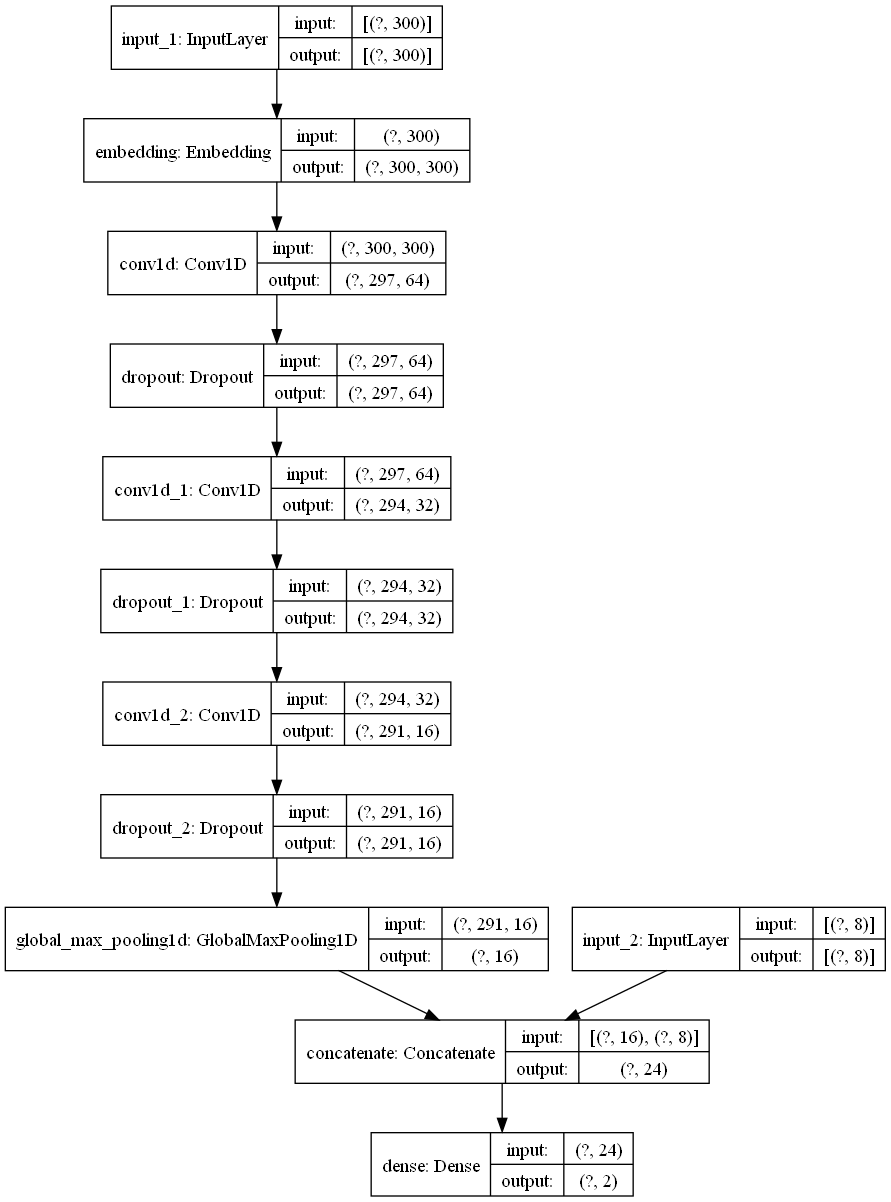

In [12]:
tf.keras.utils.plot_model(aspect_sentiment_model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [13]:
score = aspect_sentiment_model.evaluate(x=[X1_Test,X2_Test], y=Y_Test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

24/24 [==============================] - 0s 10ms/step - loss: 0.4265 - accuracy: 0.8066
Test Score: 0.42647555470466614
Test Accuracy: 0.8066225051879883


Aspect Classification

In [14]:
X_train,X_test,y_train,y_test,tokenizer=process_data_sets("review","category_id",training_data_path,test_data_path)

#supported embedding types: glove,word2vec,fasttext
embedding_matrix,vocab_size,embedding_dim=get_embedding_matrix(embedding_type,tokenizer)

aspect_class_model=CNN_Aspect_Classification_Model(X_train,y_train,embedding_matrix,vocab_size,embedding_dim)

Embeddings Matrix shape :  (10374, 300)
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 300)          3112200   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 297, 64)           76864     
_________________________________________________________________
dropout_3 (Dropout)          (None, 297, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 294, 32)           8224      
_________________________________________________________________
dropout_4 (Dropout)          (None, 294, 32)           0         
_________________________________________________________________
conv1d_5 (Conv

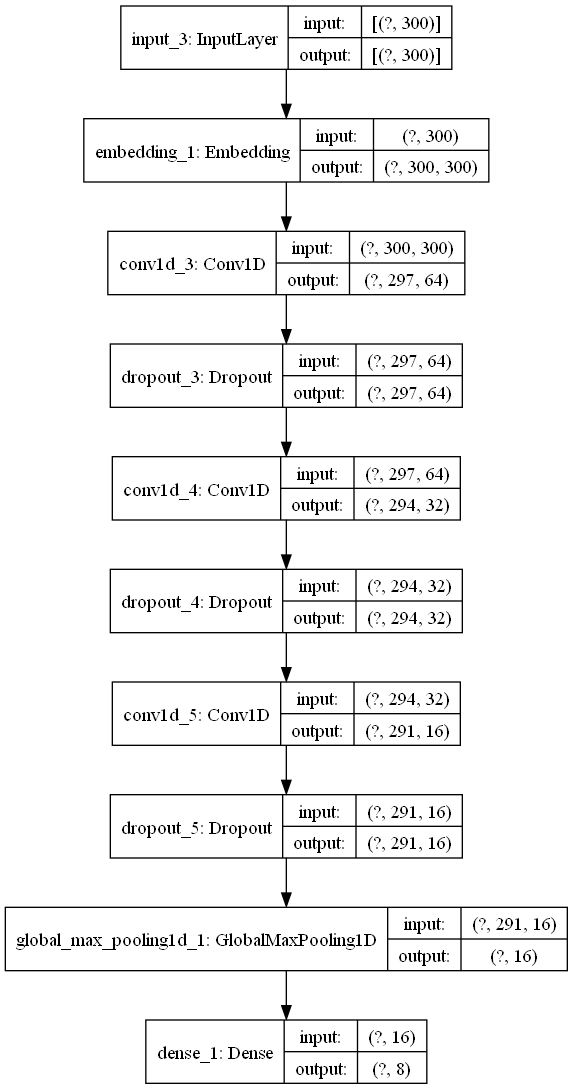

In [15]:
tf.keras.utils.plot_model(aspect_class_model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [16]:
aspect_class_pred = aspect_class_model.predict(X_test,verbose=1)
class_redictions = (aspect_class_pred == aspect_class_pred.max(axis=1)[:,None]).astype(int)
f1 = f1_score(y_test, class_redictions,average='micro')
print('F1 score: %f' % f1)

24/24 [==============================] - 0s 10ms/step
F1 score: 0.610596
